<a href="https://colab.research.google.com/github/whendo/CSCI-E25/blob/assignment12/12_OpticalFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI E-25
## Optical Flow   
### Steve Elston

In this assignment you will perform a exercises concerning optical flow. Code is provided and you are to answer the questions in the exercises.

 These exercises are derived from an [example in the Scikit Image User Guide](https://scikit-image.org/docs/stable/auto_examples/registration/plot_opticalflow.html).

> Note: Before you proceed you may need to update the version of scikit-image and the Pooch package. To do so, uncomment and execute the code in the cell below. Then shut down your Jupyter server and restart.   

In [ ]:
!pip install --upgrade scikit-image
!pip install pooch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


To get started, execute the code in the cell below to import the packages you will need for this notebook.    

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

## Iterative Lucas-Kanade (iLK) Algorithm

As a first simple example, you will apply the **iterative Lucas-Kanade** algorithm to a random field image. The random field image is generated by computing random pixel values. A second image is created by rotating the first around an axis in the image field. The goal is to register these two images and compute and display the optical flow field.   

Now, execute the code in the cell below to load and display the two images.

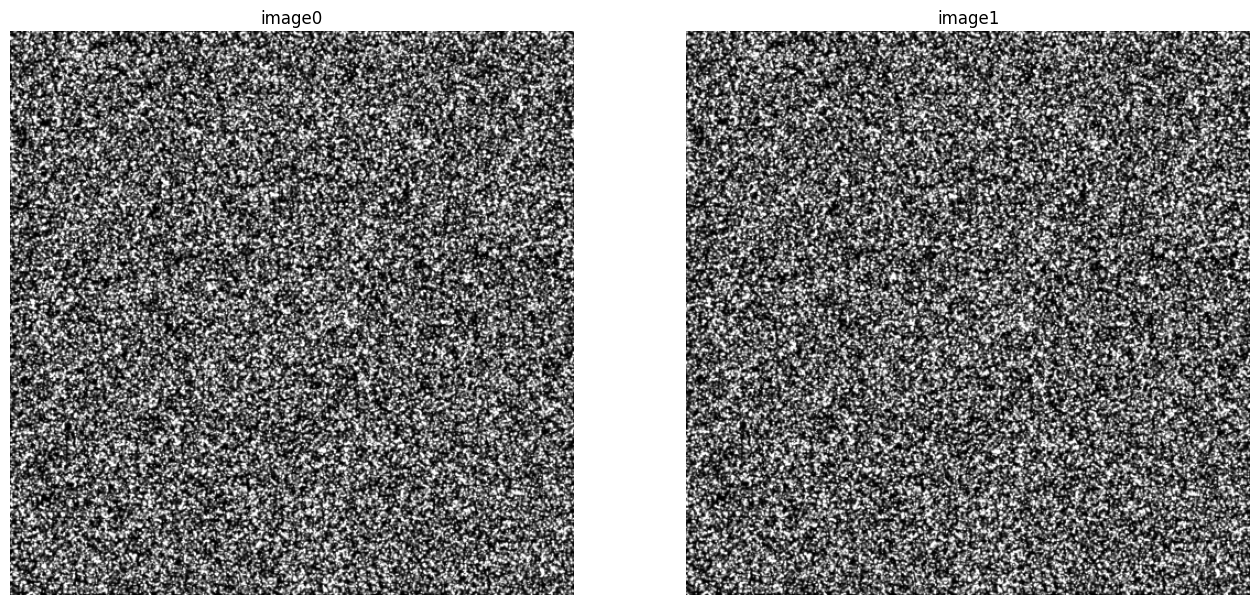

In [ ]:
def plot_grayscale(img, h=8, ax=None, title = ''):
    if(ax==None): fig, ax = plt.subplots(1,1, figsize=(h, h))
    _=ax.imshow(img, cmap=plt.get_cmap('gray'))
    _=ax.set_title(title)
    _=ax.axis('off');


image0, image1 = vortex()

fig, ax = plt.subplots(1,2, figsize=(16,8))
plot_grayscale(image0, ax=ax[0], title='image0')
plot_grayscale(image1, ax=ax[1], title='image1')

> **Exercise 12-1:** The iLK algorithm uses no smoothness constraint for regularization, imposing only the constant flow constraint. In a sentence of two, explain why for rough (random field) image the ikL algorithm with no smoothness constraint is a good choice.  

> **Answer:**  Smoothness would require knowledge of the surrounding pixels to smooth values, which is not random but dependent on its environment, so smoothing would reduce randomness and not be what we're looking for.   

You will now compute the optical flow components using iLK algorithm provided by [skimage.registration.optical_flow_ilk](https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.optical_flow_ilk). The code in the cell below does the follow operations:  

1. Compute the horizontal and vertical optical flow between the two images.
2. Compute the Euclidean norm of the flow field.
3. Plot the results.

Execute this code and examine the results.

(0.0, 1.0, 0.0, 1.0)

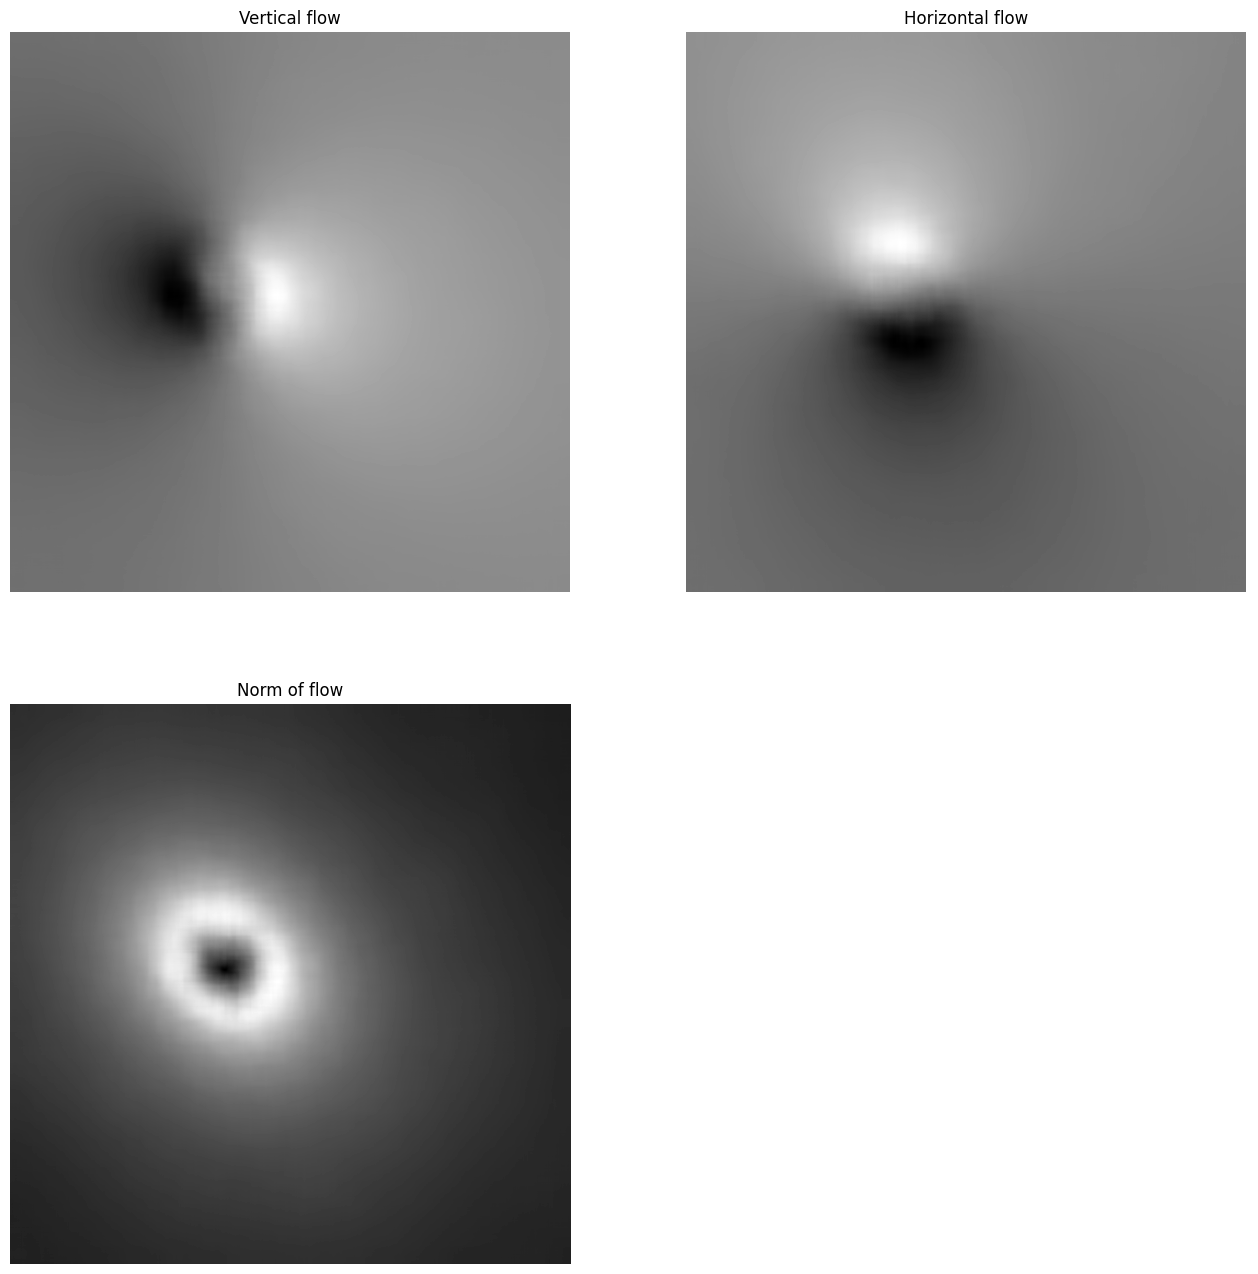

In [ ]:
# Compute the optical flow
v, u = optical_flow_ilk(image0, image1, radius=15)
# Compute flow magnitude
norm = np.sqrt(u ** 2 + v ** 2)

fig, ax = plt.subplots(2,2, figsize=(16,16))
plot_grayscale(v, ax=ax[0,0], title='Vertical flow')
plot_grayscale(u, ax=ax[0,1], title='Horizontal flow')
plot_grayscale(norm, ax=ax[1,0], title='Norm of flow')
ax[1,1].axis('off')

With the flow field computed, it is instructive to display the examine the vector flow field. The code in the cell below does just this using the quiver plot function [matplotlib.pyplot.quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html). Execute this code and examine the result.   

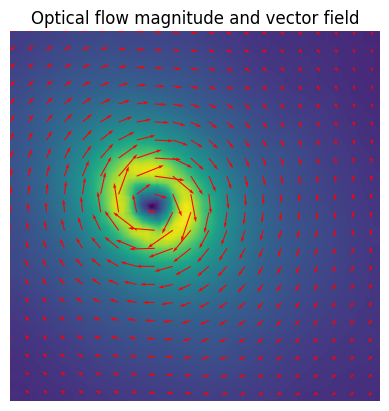

In [ ]:
# Quiver plot arguments
nvec = 20  # Number of vectors to be displayed along each image dimension
nl, nc = image0.shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

plt.imshow(norm)
plt.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)
plt.title("Optical flow magnitude and vector field")
plt.axis('off')

plt.show()

> **Exercise 12-2:** Examine the plots of the horizontal flow, vertical flow, Euclidean norm of flow and the quiver plot of the flow field. Keep in mind that for the gray-scale images of flow a bright (light) value is strongly positive and a dark value is strongly negative. In a few sentences, answer the following questions.     
> 1. How does the flow field change as you move away from the axis of rotation?  
> 2. Are the different figures showing the flow field consistent and why? Hint; compare the vector flow to the images of horizontal and vertical flow as well as the norm of the flow.

> **Answers:**
> 1. The flow field reduces in magnitude the further you are from the axis of rotation, except for the center of rotation.      
> 2. The norm of the flow appears to represent a heat map of the vector field magnitudes, but doesn't reflect the direction. The horizontal and vertical flows look almost like a stage in the vector field at a specific time, though they're the components of the norm of flow.   

## TV-L1 Algorithm

You will now work with an improved version of the TV-L1 algorithm. Here you will examine the optical flow between two time-sequential images. This image data set comes with ground truth.   

Execute the code in the cell below to load the  

In [ ]:
# Load the sequence of images and displacement
image0, image1, disp = stereo_motorcycle()

The code in the cell below displays the two images, along with the Euclidean norm of ground truth displacement. Execute this code and examine the results.

(0.0, 1.0, 0.0, 1.0)

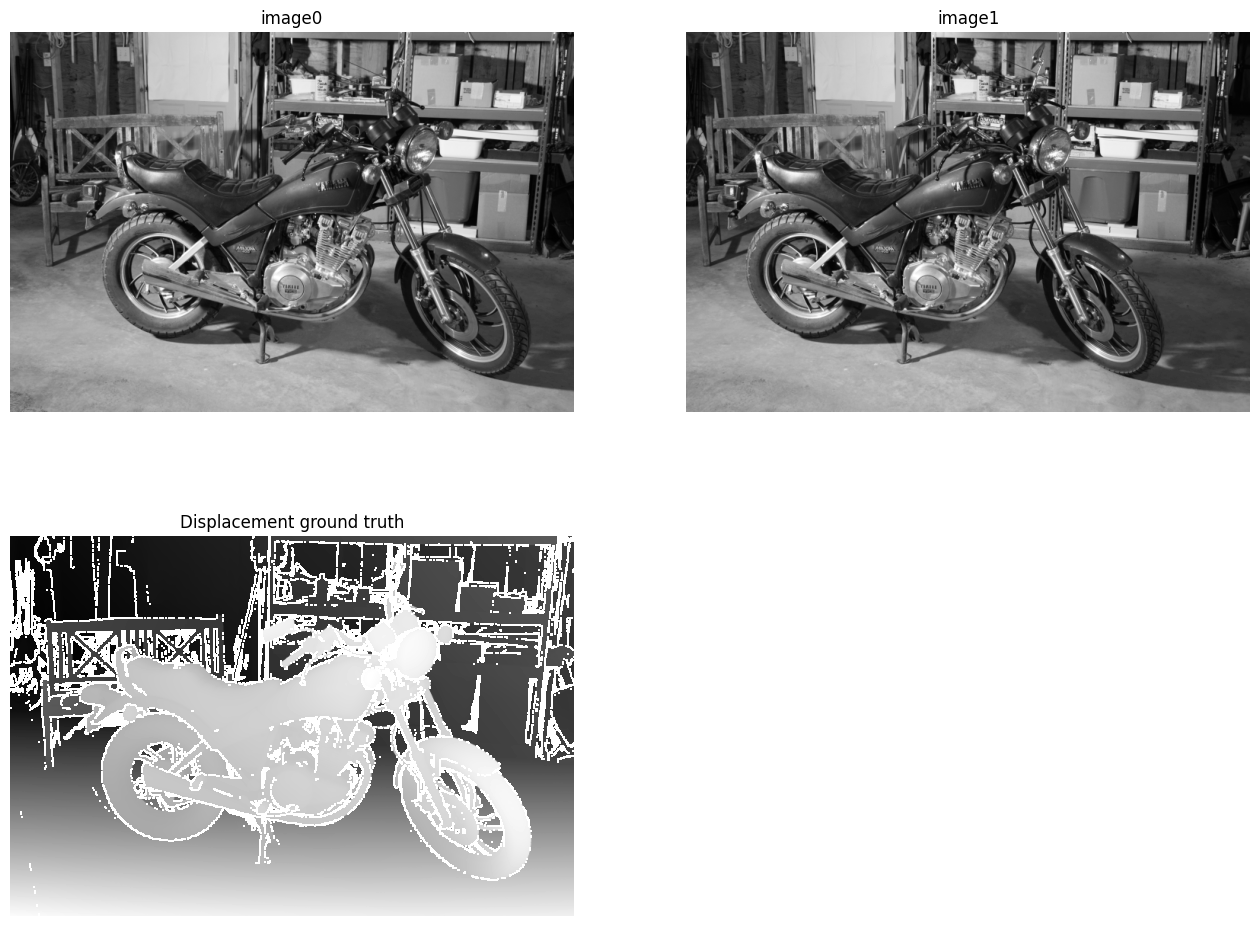

In [ ]:
image0 = rgb2gray(image0)
image1 = rgb2gray(image1)

fig, ax = plt.subplots(2,2, figsize=(16,12))
plot_grayscale(image0, ax=ax[0,0], title='image0')
plot_grayscale(image1, ax=ax[0,1], title='image1')
plot_grayscale(disp, ax=ax[1,0], title='Displacement ground truth')
ax[1,1].axis('off')

The lighter the pixel in the displacement image the greater the displacement.

Another way to view the displacement between these images is by applying an optical trick. A 3-channel (RGB) image is created from the gray-scale images. The second (displaced) image is placed in the first channel. The first (reference) image is placed in the second and third channel. In this way, displacements can be seen as red-green shadows. Execute the code in the cell below and examine the result.  

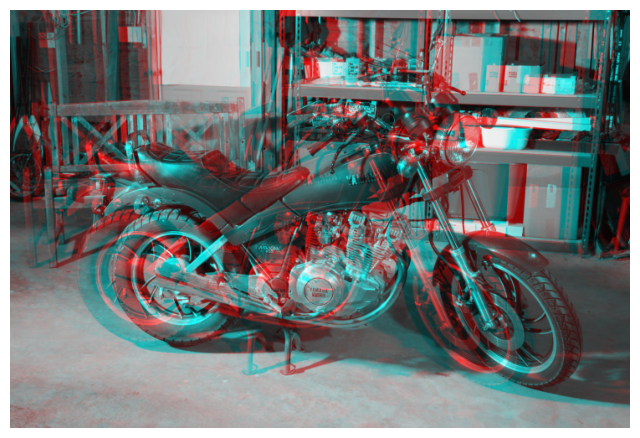

In [ ]:
def DisplacementTORGB(image0, image1):
    nr,nc = image0.shape
    seq_im = np.zeros((nr, nc, 3))
    seq_im[..., 0] = image1
    seq_im[..., 1] = image0
    seq_im[..., 2] = image0
    return(seq_im)

plot_grayscale(DisplacementTORGB(image0, image1))

The code in the cell below performs the following operations:  
1. Computes the optical flow between the two images using the TV-L1 algorithm provided by the [skimage.registration.optical_flow_tvl1](https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.optical_flow_tvl1) function.
2. Computes norm of the flow field vectors.
3. Computes the pixel-by-pixel end-point error, filter for infinite values (from zero divides), and print the average end-point error.
4. Display the vertical flow field, horizontal flow field, Euclidean norm of the flow, displacement ground truth, and end-point error field.

Execute the code and examine the results.

Average end-point error = 6.4592657


(0.0, 1.0, 0.0, 1.0)

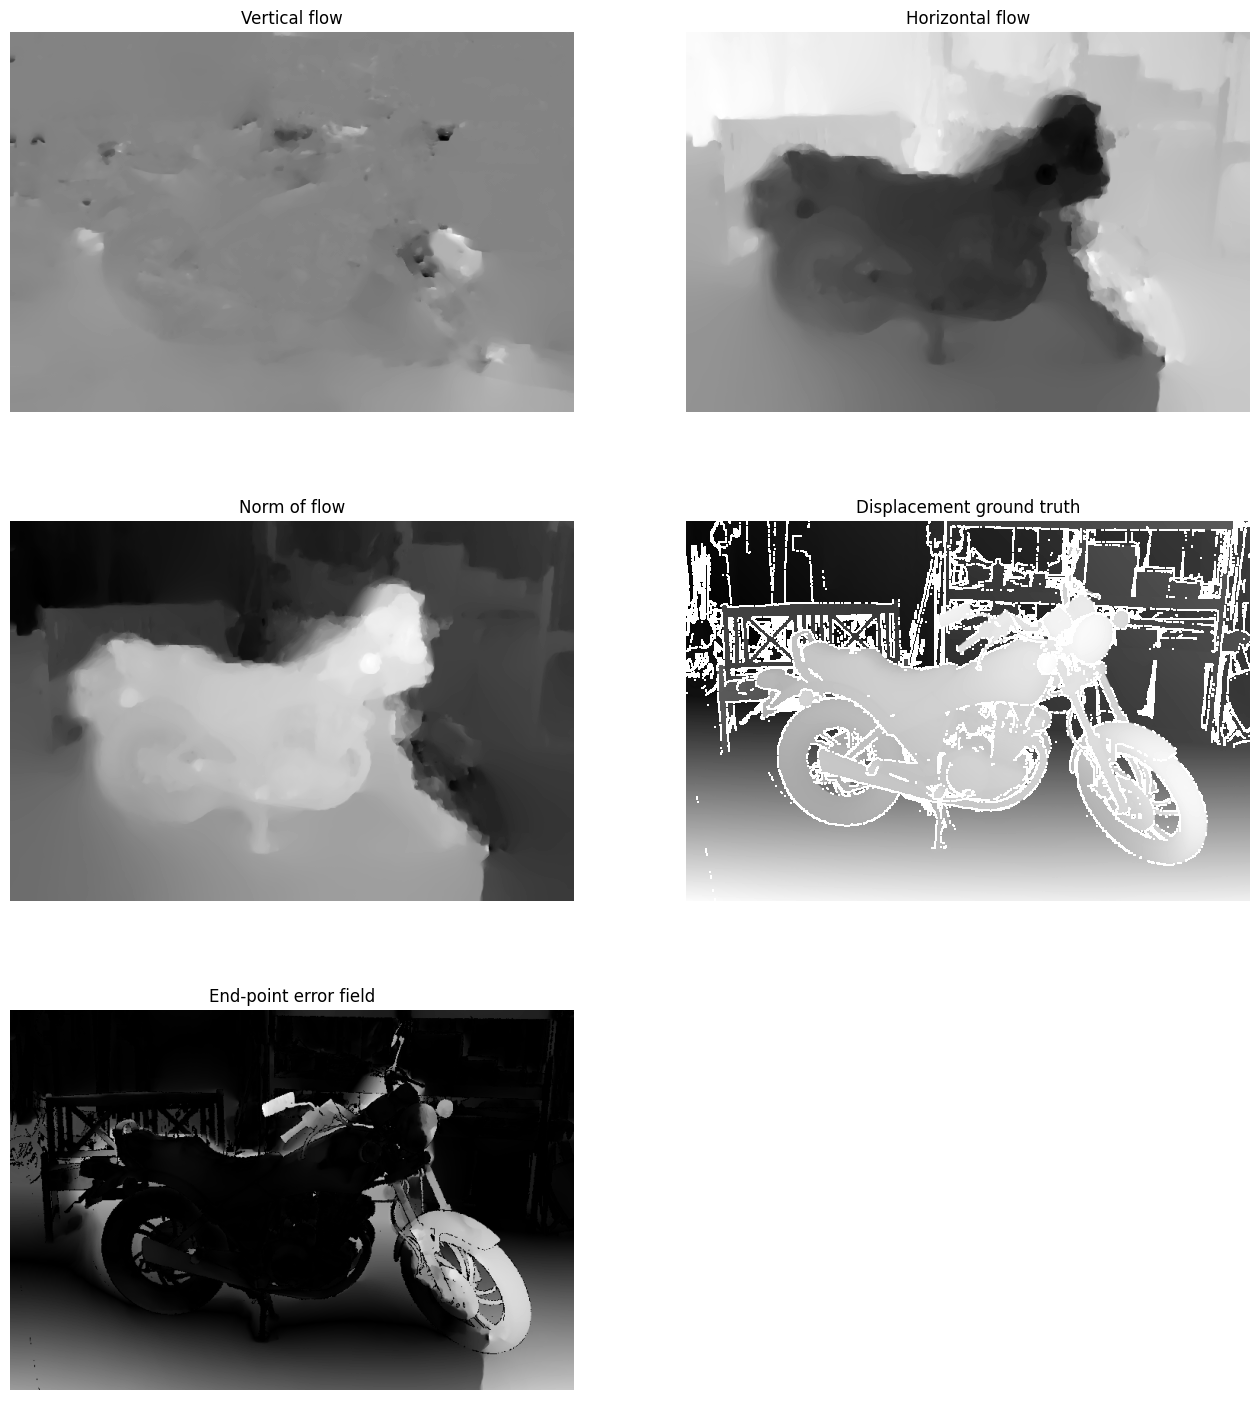

In [ ]:
v, u = optical_flow_tvl1(image0, image1)

flow_norm = np.sqrt(u ** 2 + v ** 2)

endpoint_error = np.sqrt(np.square(flow_norm - disp))
endpoint_error[endpoint_error==np.Inf] = 0.0
print('Average end-point error = ' + str(np.mean(endpoint_error)))

fig, ax = plt.subplots(3,2, figsize=(16,18))
plot_grayscale(v, ax=ax[0,0], title='Vertical flow')
plot_grayscale(u, ax=ax[0,1], title='Horizontal flow')
plot_grayscale(flow_norm, ax=ax[1,0], title='Norm of flow')
plot_grayscale(disp, ax=ax[1,1], title='Displacement ground truth')
plot_grayscale(endpoint_error, ax=ax[2,0], title='End-point error field')
ax[2,1].axis('off')
ax[2,1].axis('off')

> **Exercise 12-3:** Examine these results and answer the following questions in one or two sentences.  
> 1. This the estimated flow more vertical or horizontal, and how can you tell?  
> 2. What portion of the image exhibits the greatest error in the flow field and how can you tell.  

> **Answers:**
> 1.  The estimated horizontal flow is greater since you can identify more of an image with that flow, as well as the entire image not being washed out like in the veritical flow.   
> 2.  The right most portions of the motorcycle exhibits the greatest error in the flow field which you can see in the End-point error field. Especially the front fender, front wheel and right handlebar being more white than the rest of the motorocycle and the rest of the image in general.    

Next, execute the code in the code to display the original image first image, the warped second image, and the registered image created with the first image warped second image.  

(0.0, 1.0, 0.0, 1.0)

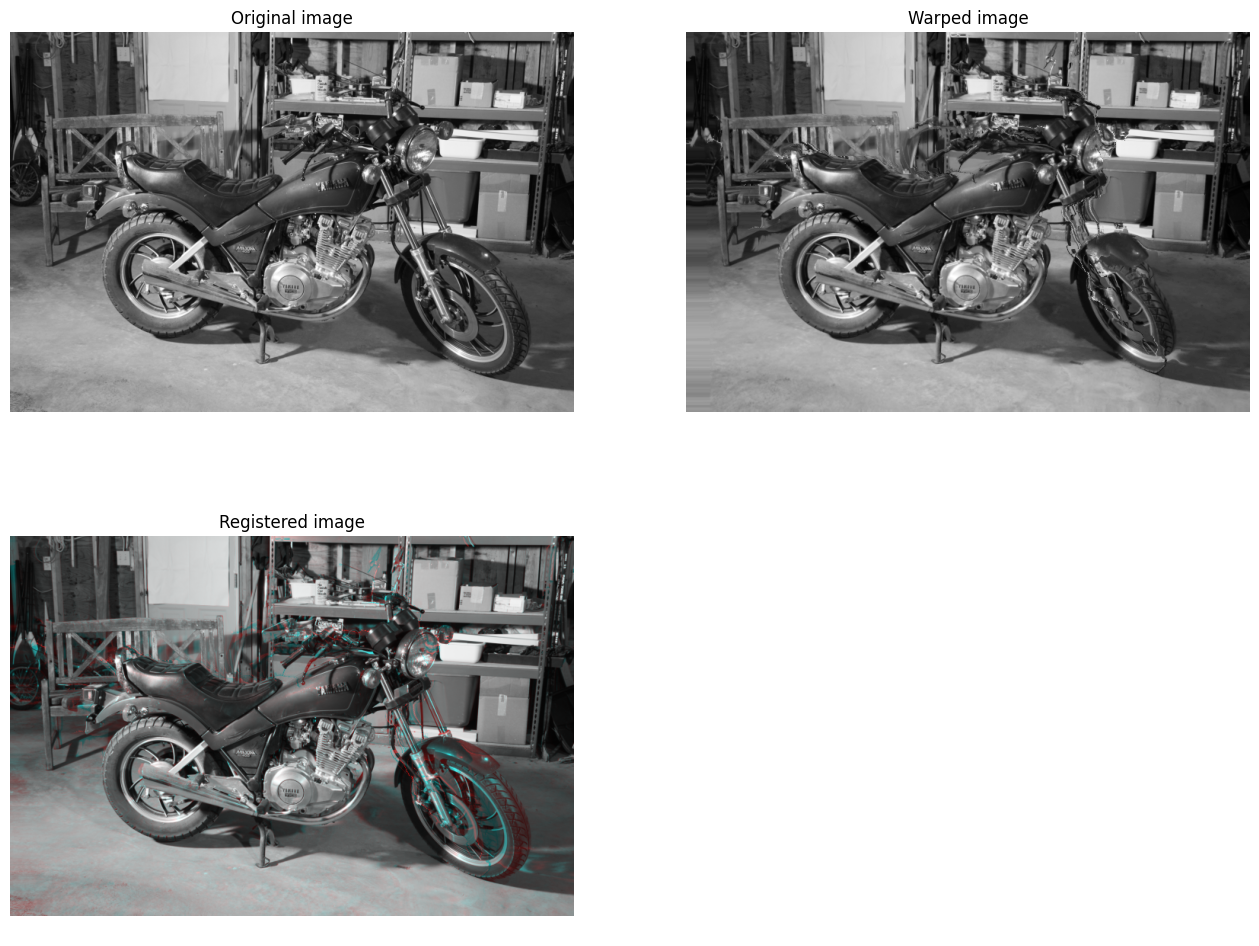

In [ ]:
nr, nc = image0.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
image1_warp = warp(image1, np.array([row_coords + v, col_coords + u]),mode='edge')

fig, ax = plt.subplots(2,2, figsize=(16,12))
plot_grayscale(DisplacementTORGB(image0, image0), ax=ax[0,0], title = 'Original image')
plot_grayscale(image1_warp, ax=ax[0,1], title = 'Warped image')
plot_grayscale(DisplacementTORGB(image0, image1_warp), ax=ax[1,0], title = 'Registered image')
ax[1,1].axis('off')

> **Exercise 12-4:** Examine these results. Where are the largest registration errors and are these consistent with the flow errors you investigated in Exercise 12-3?

> **Answer:** The largest registration errors are in the front fender, front wheel and right handlebar just like the flow error image.   

Next, you will repeat the steps of computing characteristics of the optical flow, but using the a larger parameter value, $\lamda$, 150, vs. the default value of 15 used in the first example. The larger parameter value favors brightness continuity. Execute the code and examine the results.  

Average end-point error = 5.4036055


(0.0, 1.0, 0.0, 1.0)

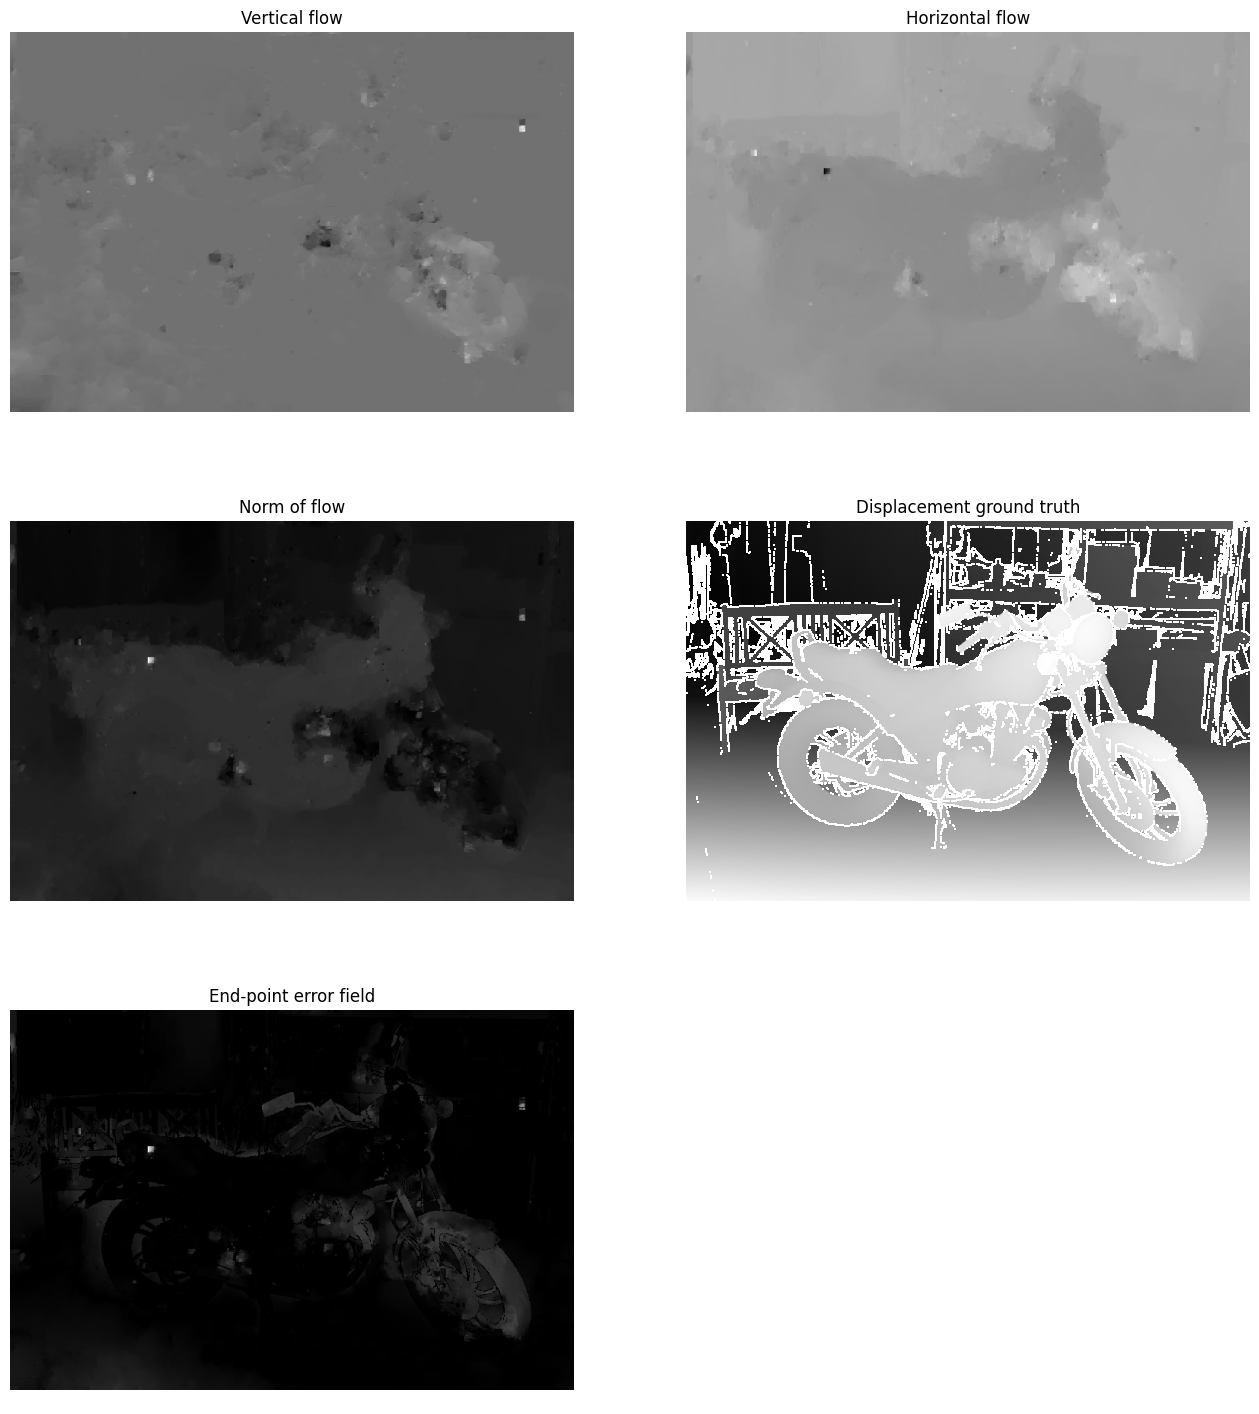

In [ ]:
v, u = optical_flow_tvl1(image0, image1, attachment=150)

flow_norm = np.sqrt(u**2 + v**2)

endpoint_error = np.sqrt(np.square(flow_norm - disp))
endpoint_error[endpoint_error==np.Inf] = 0.0
print('Average end-point error = ' + str(np.mean(endpoint_error)))

fig, ax = plt.subplots(3,2, figsize=(16,18))
plot_grayscale(v, ax=ax[0,0], title='Vertical flow')
plot_grayscale(u, ax=ax[0,1], title='Horizontal flow')
plot_grayscale(flow_norm, ax=ax[1,0], title='Norm of flow')
plot_grayscale(disp, ax=ax[1,1], title='Displacement ground truth')
plot_grayscale(endpoint_error, ax=ax[2,0], title='End-point error field')
ax[2,1].axis('off')
ax[2,1].axis('off')

> **Exercise 12-5:** Compare these results to the results with smaller value of $\lambda$ and answer the following these questions in one or two sentences.      
> 1. Comparing the average end-point errors, which value of $\lambda$ provides a better result?    
> 2. What differences can you see in the flow field images and is this expected given the value change in $\lambda$?    
> 3. What differences can you see in the end-point error fields between the two values of $\lambda$?    

> **Answers:**   
> 1. It would appear the lower $λ$ provides a better final image and a cleaner view of the gradation of values, where the higher lambda only highlights the higher values.       
> 2. The higher λ appears to make a darker norm of flow, which reflect its response to higher values vs lower ones with a smaller λ.      
> 3. The end-point error fields image for the higher λ shows only the most signficant values, and much of the detail is blacked out, where the lower λ shows the whole image, with a transition of grayscale values. The lower λ appears to produce more information, but a higher λ could act as a threshold as well.

Finally, execute the code in the code in the cell below to display the registration of the first image with the warped second image.

(0.0, 1.0, 0.0, 1.0)

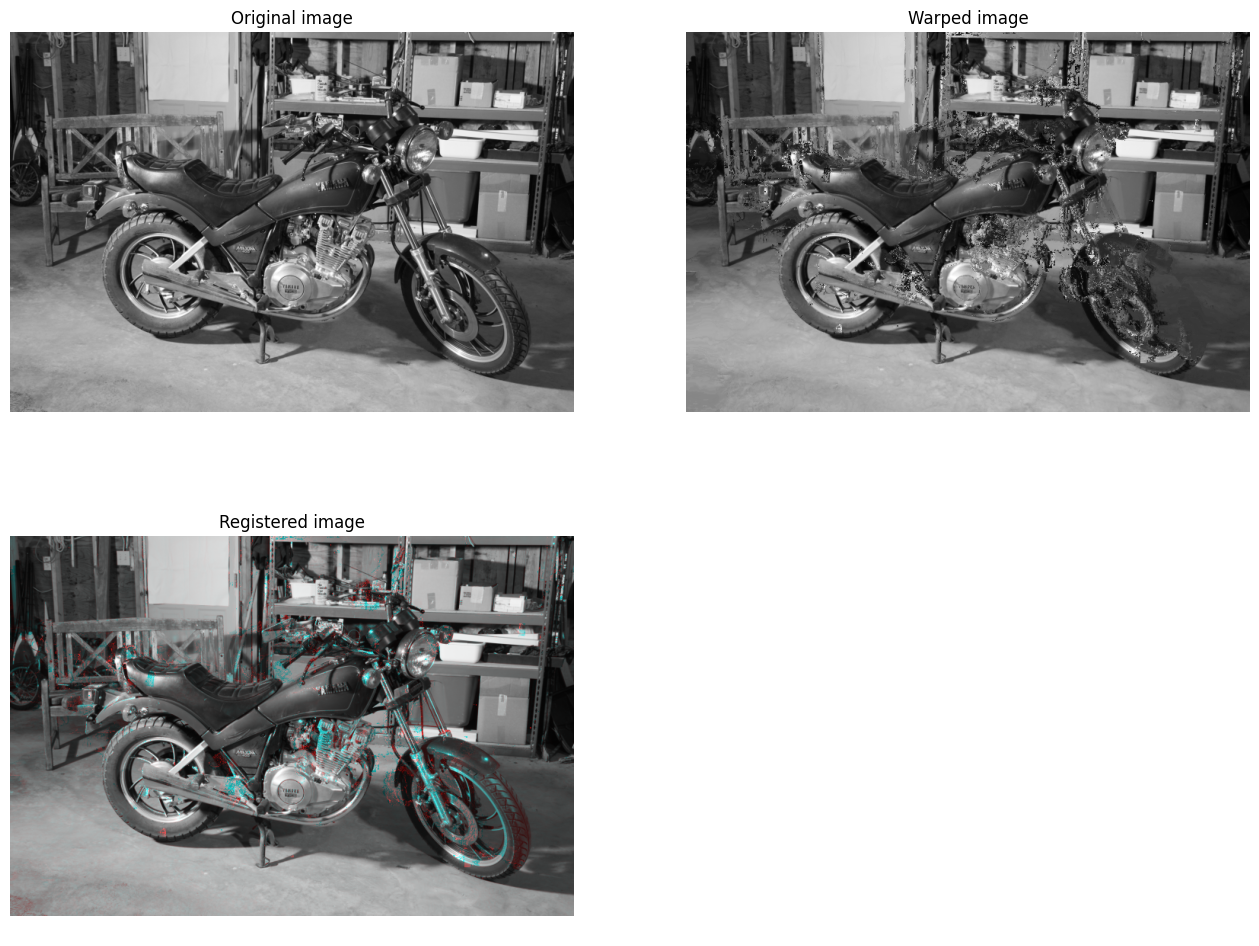

In [ ]:
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
image1_warp = warp(image1, np.array([row_coords + v, col_coords + u]),mode='edge')

fig, ax = plt.subplots(2,2, figsize=(16,12))
plot_grayscale(DisplacementTORGB(image0, image0), ax=ax[0,0], title = 'Original image')
plot_grayscale(image1_warp, ax=ax[0,1], title = 'Warped image')
plot_grayscale(DisplacementTORGB(image0, image1_warp), ax=ax[1,0], title = 'Registered image')
ax[1,1].axis('off')

These results are not particularly different from the first set. This is expected from the minimal change in average end-point error. While not great, you should be able to see that the error is in fact a bit less around the front wheel of the motorcycle.

#### Copyright 2022, 2024, Stephen F Elston. All rights reserved.